In [439]:
import os
import pandas as pd
import numpy as np
import missingno as mn
import seaborn as sns
from fancyimpute import KNN  
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.metrics import roc_auc_score, r2_score, mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [273]:
#change working directory
os.chdir(r"C:\Users\M1053735\Pictures\bikeRental")
print(os.getcwd())

C:\Users\M1053735\Pictures\bikeRental


In [274]:
#Reading Data
#Making date column as an index column
df_data = pd.read_csv("day.csv",index_col='dteday',parse_dates=True,infer_datetime_format=True)
#dropping 'instant' column because it is statisticaly insignificant
df_data = df_data.drop(columns='instant')
df_data.head(10)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.089565,88,1518,1606
2011-01-07,1,0,1,0,5,1,2,0.196522,0.208839,0.498696,0.168726,148,1362,1510
2011-01-08,1,0,1,0,6,0,2,0.165000,0.162254,0.535833,0.266804,68,891,959
2011-01-09,1,0,1,0,0,0,1,0.138333,0.116175,0.434167,0.361950,54,768,822


# Understanding The Data

In [275]:
df_data.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


instant: Record index

dteday: Date

season: Season (1:springer, 2:summer, 3:fall, 4:winter)

yr: Year (0: 2011, 1:2012)

mnth: Month (1 to 12)

hr: Hour (0 to 23)

holiday: weather day is holiday or not (extracted fromHoliday Schedule)

weekday: Day of the week

workingday: If day is neither weekend nor holiday is 1, otherwise is 0.

weathersit: (extracted fromFreemeteo)

1: Clear, Few clouds, Partly cloudy, Partly cloudy

2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered
    clouds

4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog


temp: Normalized temperature in Celsius.
The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)

atemp: Normalized feeling temperature in Celsius. 
The values are derived via (t-t_min)/(t_maxt_min), t_min=-16, t_max=+50 (only in hourly scale)

hum: Normalized humidity. The values are divided to 100 (max)

windspeed: Normalized wind speed. The values are divided to 67 (max)

casual: count of casual users

registered: count of registered users

cnt: count of total rental bikes including both casual and registered

In [276]:
df_data.shape

(731, 14)

In [277]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Data columns (total 14 columns):
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: float64(4), int64(10)
memory usage: 85.7 KB


In [278]:
#Converting to categorical variables
categorical_variables = ['season','yr','mnth','holiday','weekday','workingday','weathersit']

df_data[categorical_variables] = df_data[categorical_variables].apply(lambda x: x.astype('category'))

df_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Data columns (total 14 columns):
season        731 non-null category
yr            731 non-null category
mnth          731 non-null category
holiday       731 non-null category
weekday       731 non-null category
workingday    731 non-null category
weathersit    731 non-null category
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: category(7), float64(4), int64(3)
memory usage: 52.0 KB


# Missing Values Analysis

In [279]:
# check for missing values
df_data.isnull().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

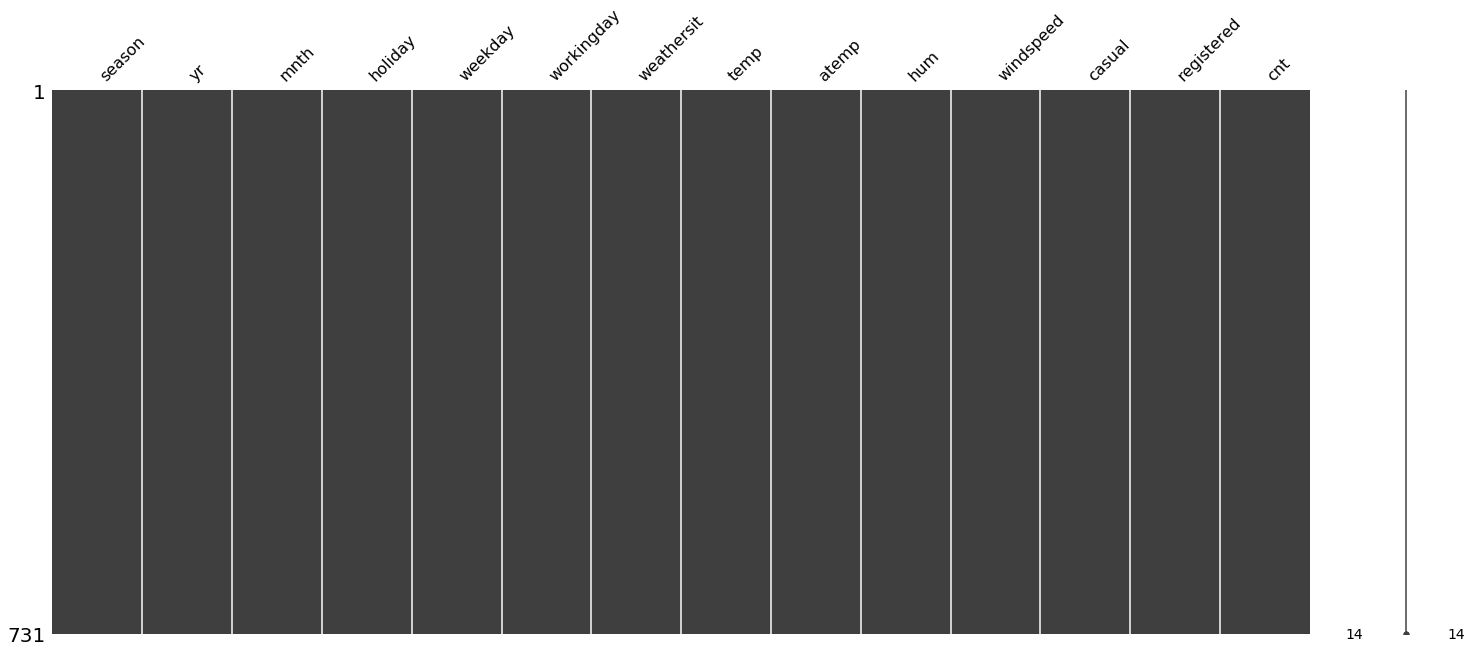

In [280]:
mn.matrix(df_data)

#### No Missing Values Found

In [281]:
#Dropping casual and registered column because they are not the target variable and the sum of both is the target variable i.e. cnt
df_data = df_data.drop(columns=['casual', 'registered'])
df_data.shape

(731, 12)

# Visualization

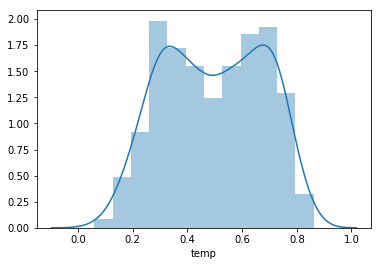

In [282]:
continuous_variables = ['temp','atemp','hum','windspeed','cnt']

#check the normal distribution of continuous variable
sns.distplot(df_data['temp'])

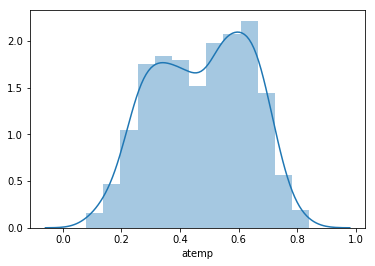

In [283]:
sns.distplot(df_data['atemp'])

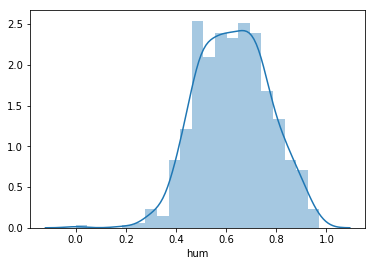

In [284]:
sns.distplot(df_data['hum'])

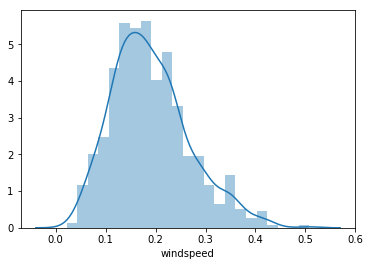

In [285]:
sns.distplot(df_data['windspeed'])

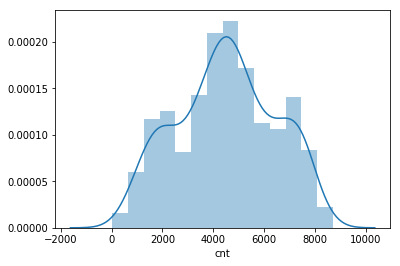

In [286]:
sns.distplot(df_data['cnt'])

In [287]:
for var in continuous_variables:
    print("Skewness of", var , ": ",df_data[var].skew(),"\n")
    


Skewness of temp :  -0.054520964760408255 

Skewness of atemp :  -0.13108804205446004 

Skewness of hum :  -0.0697834339909521 

Skewness of windspeed :  0.6773454211095377 

Skewness of cnt :  -0.04735278011900183 



### The rule of thumb seems to be:
If the skewness is between -0.5 and 0.5, the data are fairly symmetrical.
so we can say that our cnt is normally distributed

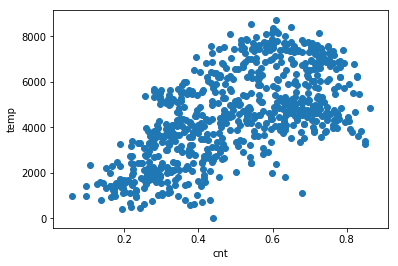

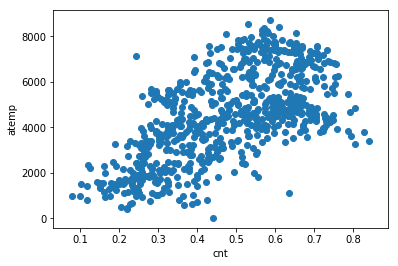

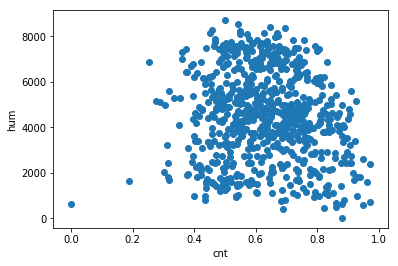

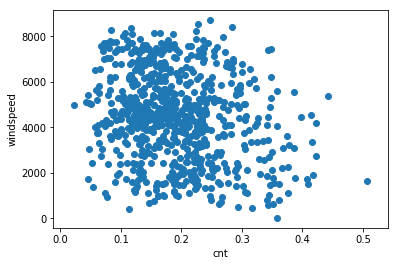

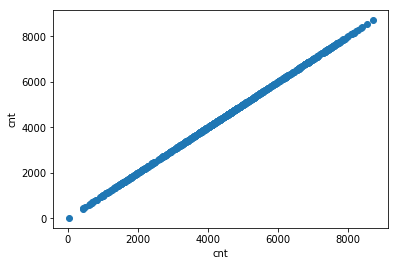

In [288]:
#check Relationship of target variable with other continuous variables
for var in continuous_variables:
    plt.scatter(x=df_data[var],y=df_data['cnt'])
    plt.xlabel('cnt')
    plt.ylabel(var)
    plt.show()

# Outliers Analysis

In [289]:
#copying the original data
df = df_data.copy()

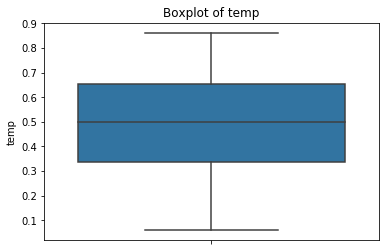

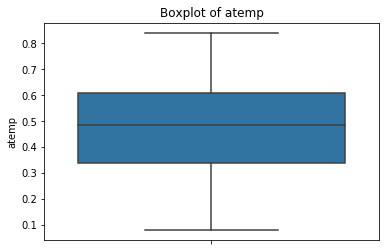

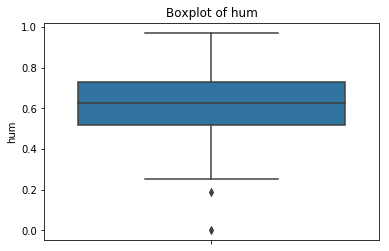

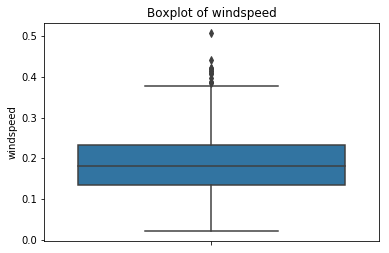

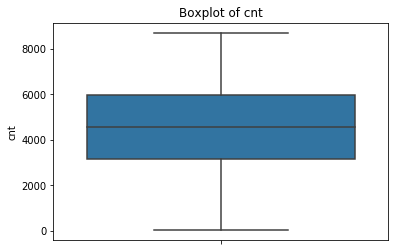

In [290]:
#Boxplots of all continuous variables
for var in continuous_variables:
    sns.boxplot(y=var,data=df)
    plt.title('Boxplot of '+var)
    plt.show()

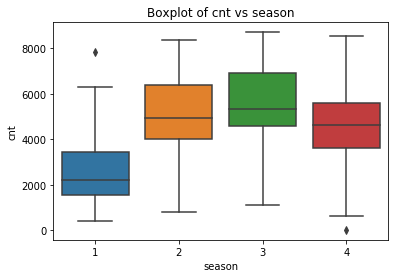

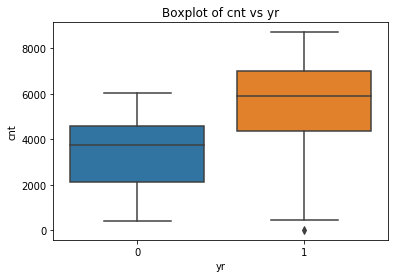

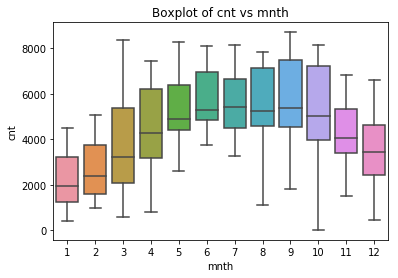

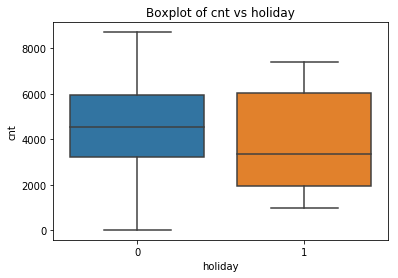

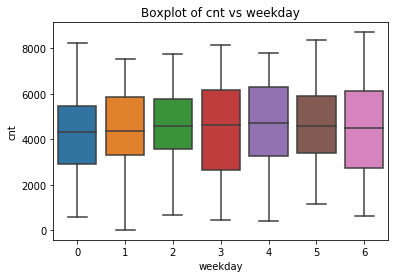

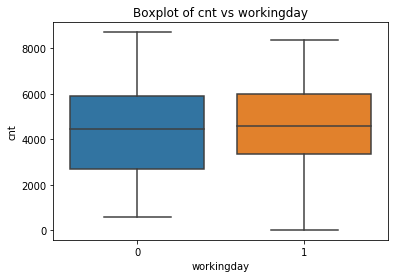

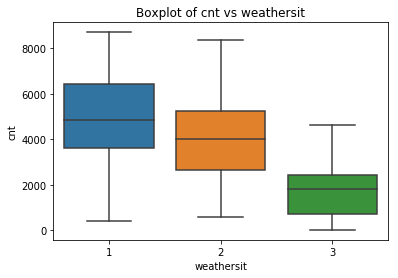

In [291]:
#check the relationship between categorical variables and target variable
for cname in categorical_variables:
        sns.boxplot(x=cname,y='cnt',data=df)
        plt.title('Boxplot of cnt vs '+cname)
        plt.show()
    
        

 windspeed and hum have outliers

### Removing Outliers

In [292]:
#checking standard deviation and shape of the data
print(df.std())
print('\n ----- Shape ---- \n',df.shape)

season           1.110807
yr               0.500342
mnth             3.451913
holiday          0.167155
weekday          2.004787
workingday       0.465233
weathersit       0.544894
temp             0.183051
atemp            0.162961
hum              0.142429
windspeed        0.077498
cnt           1937.211452
dtype: float64

 ----- Shape ---- 
 (731, 12)


In [293]:
#Dealing with outliers
names = ['windspeed','hum'] #columns names having outliers
for i in names:
    q75, q25 = np.percentile(df[i], [75 ,25])
    iqr = q75 - q25
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    df.loc[df[i] < minimum,i] = np.nan
    df.loc[df[i] > maximum,i] = np.nan
    
#Calculate missing value
missing_val = pd.DataFrame(df.isnull().sum())

In [294]:
missing_val

,0
season,0
yr,0
mnth,0
holiday,0
weekday,0
workingday,0
weathersit,0
temp,0
atemp,0
hum,2


In [295]:
#Impute with KNN
df = pd.DataFrame(KNN(k = 3).fit_transform(df), columns=df.columns,index=df_data.index)


Imputing row 1/731 with 0 missing, elapsed time: 0.108
Imputing row 101/731 with 0 missing, elapsed time: 0.109
Imputing row 201/731 with 0 missing, elapsed time: 0.110
Imputing row 301/731 with 0 missing, elapsed time: 0.110
Imputing row 401/731 with 0 missing, elapsed time: 0.111
Imputing row 501/731 with 0 missing, elapsed time: 0.111
Imputing row 601/731 with 0 missing, elapsed time: 0.111
Imputing row 701/731 with 0 missing, elapsed time: 0.112


In [296]:
df.std()

season           1.110807
yr               0.500342
mnth             3.451913
holiday          0.167155
weekday          2.004787
workingday       0.465233
weathersit       0.544894
temp             0.183051
atemp            0.162961
hum              0.139909
windspeed        0.071741
cnt           1937.211452
dtype: float64

In [297]:
df.isnull().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

In [298]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
dteday,,,,,,,,,,,,
2011-01-01,1.0,0.0,1.0,0.0,6.0,0.0,2.0,0.344167,0.363625,0.805833,0.160446,985.0
2011-01-02,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.363478,0.353739,0.696087,0.248539,801.0
2011-01-03,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.196364,0.189405,0.437273,0.248309,1349.0
2011-01-04,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.200000,0.212122,0.590435,0.160296,1562.0
2011-01-05,1.0,0.0,1.0,0.0,3.0,1.0,1.0,0.226957,0.229270,0.436957,0.186900,1600.0


# Feature Selection

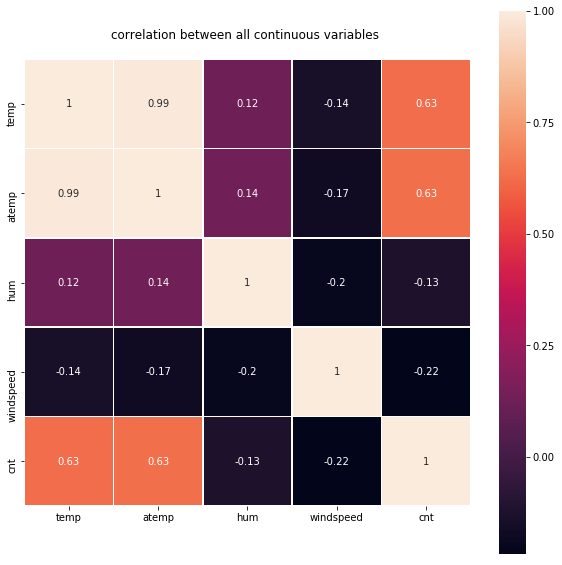

In [299]:
#plot the heat map to check correlation
df_corr = df.loc[:,continuous_variables]
f, ax = plt.subplots(figsize=(10, 10))
corr = df_corr.corr()
sns.heatmap(data=corr,annot=True,square=True,linewidths=0.5,linecolor='w')
plt.title("correlation between all continuous variables \n")
plt.show()

we can see that the variables 'temp' and 'atemp' are very highly correlated with each other.

### Chisquare test of independence

Hypothesis testing :-

    (i) Null Hypothesis: 2 variables are independent.
    
    (ii) Alternate Hypothesis: 2 variables are not independent.
    
   "p" is the probability the variables are independent.
   
If p-value is less than 0.05 then we reject the null hypothesis saying that 2 variables are dependent.

And if p-value is greater than 0.05 then we accept the null hypothesis saying that 2 variables are independent.

In [300]:
dependent_variables = []
independent_variables = []
for i in categorical_variables:
    for j in categorical_variables:
        if(i == j):
            continue
        else:
            chi2, p, dof, ex = chi2_contingency(pd.crosstab(df[i], df[j]))
            if(p < 0.5):
                dependent_variables.append((i,j,p))
            else:
                independent_variables.append((i,j,p))


In [301]:
dependent_variables

[('season', 'mnth', 0.0),
 ('season', 'weathersit', 0.021179301044733697),
 ('yr', 'weathersit', 0.12737941480418666),
 ('mnth', 'season', 0.0),
 ('mnth', 'weathersit', 0.014637111771019196),
 ('holiday', 'weekday', 8.567055344615667e-11),
 ('holiday', 'workingday', 4.033370935452143e-11),
 ('weekday', 'holiday', 8.567055344615637e-11),
 ('weekday', 'workingday', 6.775030505809736e-136),
 ('weekday', 'weathersit', 0.2784593307450517),
 ('workingday', 'holiday', 4.033370935452143e-11),
 ('workingday', 'weekday', 6.775030505809736e-136),
 ('workingday', 'weathersit', 0.2537639982644043),
 ('weathersit', 'season', 0.02117930104473366),
 ('weathersit', 'yr', 0.12737941480418666),
 ('weathersit', 'mnth', 0.014637111771019196),
 ('weathersit', 'weekday', 0.27845933074505175),
 ('weathersit', 'workingday', 0.2537639982644043)]

features to be selected from above info:

    (i)season have high dependency with mnth and weathersit with p value ~ 0 so we will keep season and discard mnth and    weathersit
    
    (ii)holiday have high dependency with weekday and workingday so we will keep holiday and discard other two
    
    (iii)yr have dependency with weathersit and we already discarded the weathersit so we will keep yr

In [302]:
#Before dropping columns
df.shape

(731, 12)

In [303]:
df =df.drop(columns=['mnth','weathersit','weekday','workingday'])

In [304]:
#dropping atemp because of its high correlation with temp
df = df.drop(columns=['atemp'])
#After dropping columns
df.shape

(731, 7)

In [305]:
df.describe()

,season,yr,holiday,temp,hum,windspeed,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,0.028728,0.495385,0.629722,0.186642,4504.348837
std,1.110807,0.500342,0.167155,0.183051,0.139909,0.071741,1937.211452
min,1.000000,0.000000,0.000000,0.059130,0.254167,0.022392,22.000000
25%,2.000000,0.000000,0.000000,0.337083,0.522291,0.134340,3152.000000
50%,3.000000,1.000000,0.000000,0.498333,0.629167,0.179117,4548.000000
75%,3.000000,1.000000,0.000000,0.655417,0.730833,0.230723,5956.000000
max,4.000000,1.000000,1.000000,0.861667,0.972500,0.378108,8714.000000


#### Performing one hot encoding for categorical variables

Below link helps me to understand it better

https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f

In [306]:
one_hot_vars = ['season','yr','holiday']
#creating dummies 
for i in one_hot_vars:
    temp = pd.get_dummies(df[i],prefix=i)
    df = df.join(temp)
#dropping variables which are used for one hot encodng
df = df.drop(columns=one_hot_vars)

In [307]:
df.head()

,temp,hum,windspeed,cnt,season_1.0,season_2.0,season_3.0,season_4.0,yr_0.0,yr_1.0,holiday_0.0,holiday_1.0
dteday,,,,,,,,,,,,
2011-01-01,0.344167,0.805833,0.160446,985.0,1,0,0,0,1,0,1,0
2011-01-02,0.363478,0.696087,0.248539,801.0,1,0,0,0,1,0,1,0
2011-01-03,0.196364,0.437273,0.248309,1349.0,1,0,0,0,1,0,1,0
2011-01-04,0.200000,0.590435,0.160296,1562.0,1,0,0,0,1,0,1,0
2011-01-05,0.226957,0.436957,0.186900,1600.0,1,0,0,0,1,0,1,0


# Feature Scaling

In [308]:
#quickly check the variance of continuos variables
vars = ['temp','hum','windspeed','cnt']
df[vars].var()

temp         3.350767e-02
hum          1.957466e-02
windspeed    5.146815e-03
cnt          3.752788e+06
dtype: float64

In [309]:
#Normalisation
for i in vars:
    print(i)
    df[i] = (df[i] - min(df[i]))/(max(df[i]) - min(df[i]))

temp
hum
windspeed
cnt


In [310]:
df.head()

,temp,hum,windspeed,cnt,season_1.0,season_2.0,season_3.0,season_4.0,yr_0.0,yr_1.0,holiday_0.0,holiday_1.0
dteday,,,,,,,,,,,,
2011-01-01,0.355170,0.767981,0.388102,0.110792,1,0,0,0,1,0,1,0
2011-01-02,0.379232,0.615202,0.635752,0.089623,1,0,0,0,1,0,1,0
2011-01-03,0.171000,0.254904,0.635105,0.152669,1,0,0,0,1,0,1,0
2011-01-04,0.175530,0.468123,0.387681,0.177174,1,0,0,0,1,0,1,0
2011-01-05,0.209120,0.254464,0.462471,0.181546,1,0,0,0,1,0,1,0


In [311]:
df[vars].describe()

,temp,hum,windspeed,cnt
count,731.000000,731.000000,731.000000,731.000000
mean,0.543594,0.522814,0.461747,0.515687
std,0.228091,0.194770,0.201681,0.222873
min,0.000000,0.000000,0.000000,0.000000
25%,0.346343,0.373259,0.314711,0.360101
50%,0.547268,0.522042,0.440591,0.520709
75%,0.743002,0.663573,0.585667,0.682697
max,1.000000,1.000000,1.000000,1.000000


In [312]:
df.head()

,temp,hum,windspeed,cnt,season_1.0,season_2.0,season_3.0,season_4.0,yr_0.0,yr_1.0,holiday_0.0,holiday_1.0
dteday,,,,,,,,,,,,
2011-01-01,0.355170,0.767981,0.388102,0.110792,1,0,0,0,1,0,1,0
2011-01-02,0.379232,0.615202,0.635752,0.089623,1,0,0,0,1,0,1,0
2011-01-03,0.171000,0.254904,0.635105,0.152669,1,0,0,0,1,0,1,0
2011-01-04,0.175530,0.468123,0.387681,0.177174,1,0,0,0,1,0,1,0
2011-01-05,0.209120,0.254464,0.462471,0.181546,1,0,0,0,1,0,1,0


# Splitting data into train and test

In [313]:
train, test = train_test_split(df,test_size=0.2)

In [314]:
train.head()

,temp,hum,windspeed,cnt,season_1.0,season_2.0,season_3.0,season_4.0,yr_0.0,yr_1.0,holiday_0.0,holiday_1.0
dteday,,,,,,,,,,,,
2011-03-17,0.443431,0.485499,0.526226,0.313162,1,0,0,0,1,0,1,0
2012-10-24,0.658374,0.531902,0.141651,0.882536,0,0,0,1,0,1,1,0
2012-08-28,0.833859,0.509281,0.473786,0.807409,0,0,1,0,0,1,1,0
2011-02-23,0.202618,0.235094,0.201625,0.218017,1,0,0,0,1,0,1,0
2011-04-06,0.413318,0.301623,0.676582,0.320525,0,1,0,0,1,0,1,0


In [315]:
test.head()

,temp,hum,windspeed,cnt,season_1.0,season_2.0,season_3.0,season_4.0,yr_0.0,yr_1.0,holiday_0.0,holiday_1.0
dteday,,,,,,,,,,,,
2012-07-13,0.838014,0.322505,0.164340,0.860216,0,0,1,0,0,1,1,0
2012-11-14,0.286637,0.414732,0.498243,0.629659,0,0,0,1,0,1,1,0
2012-05-17,0.665643,0.370069,0.582159,0.846986,0,1,0,0,0,1,1,0
2012-12-28,0.241986,0.467517,0.374116,0.353543,1,0,0,0,0,1,1,0
2011-09-09,0.736253,0.896172,0.286710,0.405200,0,0,1,0,1,0,1,0


In [316]:
train_feature_variables = train.copy().drop(columns=['cnt'])
test_feature_variables = test.copy().drop(columns=['cnt'])

train_target_variable = pd.DataFrame(train['cnt'])
test_target_variable = pd.DataFrame(test['cnt'])

# Model Development

### Decision Tree

In [400]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [391]:
features =df.copy().drop(columns=['cnt'])
target = df.copy().drop(columns=['temp', 'hum', 'windspeed', 'season_1.0', 'season_2.0',
       'season_3.0', 'season_4.0', 'yr_0.0', 'yr_1.0', 'holiday_0.0',
       'holiday_1.0'])
d_tree = DecisionTreeRegressor()
# Applying Grid Search to find the best parameters
parameters = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              }
grid_search = GridSearchCV(estimator=d_tree, param_grid=parameters,cv=5,n_jobs=-1)

grid_search.fit(features,target)


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [2, 6, 8],
                         'max_leaf_nodes': [5, 20, 100],
                      

In [392]:
grid_search.best_score_

0.04093814520572103

In [393]:
grid_search.best_params_

{'criterion': 'mse',
 'max_depth': 8,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 20,
 'min_samples_split': 10}

In [395]:
tree = DecisionTreeRegressor(criterion='mse',max_depth=8,max_leaf_nodes=100,min_samples_leaf=10,min_samples_split=10)

In [396]:
tree.fit(train_feature_variables,train_target_variable)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8,
                      max_features=None, max_leaf_nodes=100,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [397]:
prediction = tree.predict(test_feature_variables)
prediction = pd.DataFrame(prediction)
prediction = prediction.set_index(test_target_variable.index).rename(columns = {0:'cnt'})


In [407]:
#calculate RMSE on test data
print("R2 Score:",r2_score(test_target_variable,prediction))
print("Mean Absolute Error:",mean_absolute_error(test_target_variable,prediction))
print("Mean Squared Error:",mean_squared_error(test_target_variable,prediction))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(test_target_variable,prediction)))
print("MAPE:",mean_absolute_percentage_error(test_target_variable,prediction))
print("Accuracy:",(100 - mean_absolute_percentage_error(test_target_variable,prediction)))

R2 Score: 0.8538822024169046
Mean Absolute Error: 0.06448892461923823
Mean Squared Error: 0.00797092699887646
Root Mean Squared Error: 0.08928004815677723
MAPE: cnt    21.600067
dtype: float64
Accuracy: cnt    78.399933
dtype: float64


In [404]:
#calculate RMSE on training data
pred = pd.DataFrame(tree.predict(train_feature_variables))
pred = pred.set_index(train_target_variable.index).rename(columns = {0:'cnt'})
print("R2 Score:",r2_score(train_target_variable,pred))
print("Mean Absolute Error:",mean_absolute_error(train_target_variable,pred))
print("Mean Squared Error:",mean_squared_error(train_target_variable,pred))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(train_target_variable,pred)))
print("MAPE:",mean_absolute_percentage_error(train_target_variable,pred))
print("Accuracy:",(100 - mean_absolute_percentage_error(train_target_variable,pred)))

R2 Score: 0.8636098579490773
Mean Absolute Error: 0.058641751634872154
Mean Squared Error: 0.006590866242788196
Root Mean Squared Error: 0.081184150194408
MAPE: cnt    inf
dtype: float64
Accuracy: cnt   -inf
dtype: float64


## Linear Regression

In [410]:
model = LinearRegression()
#Grid Search
parameters =  {'copy_X':[True, False],
          'fit_intercept':[True,False]}
model_grid = GridSearchCV(estimator=model,param_grid=parameters,cv=5,scoring='r2')
model_grid.fit(features,target)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [411]:
print("Best score:",model_grid.best_score_,'\n Best Parameters :',model_grid.best_params_)

Best score: 0.32099064163348145 
 Best Parameters : {'copy_X': True, 'fit_intercept': False}


In [417]:
model = LinearRegression(copy_X= True, fit_intercept=False).fit(train_feature_variables,train_target_variable)
prediction = model.predict(test_feature_variables)
prediction = pd.DataFrame(prediction)
prediction = prediction.set_index(test_target_variable.index).rename(columns = {0:'cnt'})

In [414]:
#calculate RMSE on test data
print("R2 Score:",r2_score(test_target_variable,prediction))
print("Mean Absolute Error:",mean_absolute_error(test_target_variable,prediction))
print("Mean Squared Error:",mean_squared_error(test_target_variable,prediction))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(test_target_variable,prediction)))
print("MAPE:",mean_absolute_percentage_error(test_target_variable,prediction))
print("Accuracy:",(100 - mean_absolute_percentage_error(test_target_variable,prediction)))

R2 Score: 0.8191423791114653
Mean Absolute Error: 0.07372336877405293
Mean Squared Error: 0.009866032181830303
Root Mean Squared Error: 0.0993279023327801
MAPE: cnt    20.09239
dtype: float64
Accuracy: cnt    79.90761
dtype: float64


In [416]:
#calculate RMSE on training data
pred = pd.DataFrame(model.predict(train_feature_variables))
pred = pred.set_index(train_target_variable.index).rename(columns = {0:'cnt'})
print("R2 Score:",r2_score(train_target_variable,pred))
print("Mean Absolute Error:",mean_absolute_error(train_target_variable,pred))
print("Mean Squared Error:",mean_squared_error(train_target_variable,pred))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(train_target_variable,pred)))
print("MAPE:",mean_absolute_percentage_error(train_target_variable,pred))
print("Accuracy:",(100 - mean_absolute_percentage_error(train_target_variable,pred)))

R2 Score: 0.7933088676507639
Mean Absolute Error: 0.07385713999864145
Mean Squared Error: 0.009988065019945709
Root Mean Squared Error: 0.0999403072836266
MAPE: cnt    inf
dtype: float64
Accuracy: cnt   -inf
dtype: float64


## Random Forest

In [431]:
# Create the random grid
parameters = {'n_estimators': list(range(100,700,100)),
               'max_depth': list(range(10,20,1)),
               'min_samples_split':range(2,5,1)}

Forest = RandomForestRegressor()

# Instantiate the gridSearchCV object: Forest
Forest_grid = GridSearchCV(estimator=Forest, param_grid=parameters, cv=5,n_jobs=-1)
Forest_grid.fit(features,target.values.ravel())
print("Best score:",Forest_grid.best_score_,'\n Best Parameters :',Forest_grid.best_params_)


Best score: 0.30408577443144286 
 Best Parameters : {'max_depth': 11, 'min_samples_split': 4, 'n_estimators': 100}


In [435]:
Forest = RandomForestRegressor(max_depth= 11, min_samples_split=4,n_estimators=100)
Forest.fit(train_feature_variables,train_target_variable.values.ravel())
prediction = Forest.predict(test_feature_variables)
prediction = pd.DataFrame(prediction)
prediction = prediction.set_index(test_target_variable.index).rename(columns = {0:'cnt'})

In [436]:
#calculate RMSE on test data
print("R2 Score:",r2_score(test_target_variable,prediction))
print("Mean Absolute Error:",mean_absolute_error(test_target_variable,prediction))
print("Mean Squared Error:",mean_squared_error(test_target_variable,prediction))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(test_target_variable,prediction)))
print("MAPE:",mean_absolute_percentage_error(test_target_variable,prediction))
print("Accuracy:",(100 - mean_absolute_percentage_error(test_target_variable,prediction)))

R2 Score: 0.9091978063123916
Mean Absolute Error: 0.053799024998306445
Mean Squared Error: 0.004953384660825899
Root Mean Squared Error: 0.07038028602404156
MAPE: cnt    16.624133
dtype: float64
Accuracy: cnt    83.375867
dtype: float64


In [437]:
#calculate RMSE on training data
pred = pd.DataFrame(Forest.predict(train_feature_variables))
pred = pred.set_index(train_target_variable.index).rename(columns = {0:'cnt'})
print("R2 Score:",r2_score(train_target_variable,pred))
print("Mean Absolute Error:",mean_absolute_error(train_target_variable,pred))
print("Mean Squared Error:",mean_squared_error(train_target_variable,pred))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(train_target_variable,pred)))
print("MAPE:",mean_absolute_percentage_error(train_target_variable,pred))
print("Accuracy:",(100 - mean_absolute_percentage_error(train_target_variable,pred)))

R2 Score: 0.9644129258144957
Mean Absolute Error: 0.029953503572398277
Mean Squared Error: 0.0017196964707410338
Root Mean Squared Error: 0.041469223175037095
MAPE: cnt    inf
dtype: float64
Accuracy: cnt   -inf
dtype: float64


## Gradient Boosting

In [441]:
GB = GradientBoostingRegressor().fit(train_feature_variables, train_target_variable.values.ravel())
# predict on train data
prediction = GB.predict(test_feature_variables)
prediction = pd.DataFrame(prediction)
prediction = prediction.set_index(test_target_variable.index).rename(columns = {0:'cnt'})

In [442]:
#calculate RMSE on test data
print("R2 Score:",r2_score(test_target_variable,prediction))
print("Mean Absolute Error:",mean_absolute_error(test_target_variable,prediction))
print("Mean Squared Error:",mean_squared_error(test_target_variable,prediction))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(test_target_variable,prediction)))
print("MAPE:",mean_absolute_percentage_error(test_target_variable,prediction))
print("Accuracy:",(100 - mean_absolute_percentage_error(test_target_variable,prediction)))

R2 Score: 0.9097211561096751
Mean Absolute Error: 0.05159056187627023
Mean Squared Error: 0.004924835208958808
Root Mean Squared Error: 0.07017717014071463
MAPE: cnt    14.720545
dtype: float64
Accuracy: cnt    85.279455
dtype: float64


In [443]:
#calculate RMSE on training data
pred = pd.DataFrame(Forest.predict(train_feature_variables))
pred = pred.set_index(train_target_variable.index).rename(columns = {0:'cnt'})
print("R2 Score:",r2_score(train_target_variable,pred))
print("Mean Absolute Error:",mean_absolute_error(train_target_variable,pred))
print("Mean Squared Error:",mean_squared_error(train_target_variable,pred))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(train_target_variable,pred)))
print("MAPE:",mean_absolute_percentage_error(train_target_variable,pred))
print("Accuracy:",(100 - mean_absolute_percentage_error(train_target_variable,pred)))

R2 Score: 0.9644129258144957
Mean Absolute Error: 0.029953503572398277
Mean Squared Error: 0.0017196964707410338
Root Mean Squared Error: 0.041469223175037095
MAPE: cnt    inf
dtype: float64
Accuracy: cnt   -inf
dtype: float64



### From above models, it is clear that Gradient Boosting Model is providing best results having R-squared = 0.90 and Accuracy = 85.27%